# 02_train
- Author: 
- Date: 2025-10-23
- Goal: 모델링/학습/통계/시각화
- Input: 
- Output: 
- Metrics: acc@val, loss@train
- Repro: seed=42, device=auto, config=../configs/


In [1]:
# This cell is only needed if xgboost is not installed in your environment.
# In Colab, run this once and then restart the runtime if necessary.
# option Cell !!! 
# xgboost 안깔려 있으면 주석 풀고 실행!
#!pip install -q xgboost

In [2]:
# ================================================================
# 02. Classical ML Training on Colored MNIST
#    - Uses preprocessed 100k Colored MNIST npz (train / val only)
#    - Features: flattened RGB (28*28*3 = 2352)
#    - Tasks:
#        * Digit classification (0-9)
#        * Foreground color classification (0-6, ROYG BIV)
#        * Background color classification (0-6, ROYG BIV)
#    - Models:
#        * Logistic Regression, KNN, SVM, Decision Tree, Random Forest, XGBoost
#    - Only validation set is used for evaluation (no test set yet)
#    - Outputs:
#        * Per-task / per-model metrics CSV
#        * Confusion matrices
#        * Feature importance heatmaps (tree-based models)
#        * Qualitative prediction examples
# ================================================================


# ================================
# Cell 1. Imports & global config
# ================================
import os
import random
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
)

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# XGBoost (install if necessary: !pip install xgboost)
from xgboost import XGBClassifier

# For notebook
%matplotlib inline

# Global random seed for reproducibility
RANDOM_SEED = 0
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Matplotlib configuration
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["axes.unicode_minus"] = False

print("[INFO] Libraries imported.")


[INFO] Libraries imported.


In [3]:
# ===================================
# Cell 2. Paths & dataset information
# ===================================
# Assume this notebook is placed at project root
BASE_DIR = os.getcwd()

# Directory where preprocessed npz is saved
PROC_DIR = os.path.join(BASE_DIR, "data", "processed", "colored_mnist")

# *** IMPORTANT: this must match 01_preprocessing_colored_mnist.ipynb ***
NPZ_PATH = os.path.join(PROC_DIR, "colored_mnist_100k_train_val.npz")

# Output directories for metrics and figures
RESULTS_METRICS_DIR = os.path.join(BASE_DIR, "results", "metrics")
RESULTS_FIGURES_DIR = os.path.join(BASE_DIR, "results", "figures")

os.makedirs(RESULTS_METRICS_DIR, exist_ok=True)
os.makedirs(RESULTS_FIGURES_DIR, exist_ok=True)

# Shape of a colored image (for visualization only)
IMG_SHAPE = (28, 28, 3)

print("[INFO] BASE_DIR      :", BASE_DIR)
print("[INFO] NPZ_PATH      :", NPZ_PATH)
print("[INFO] METRICS_DIR   :", RESULTS_METRICS_DIR)
print("[INFO] FIGURES_DIR   :", RESULTS_FIGURES_DIR)


[INFO] BASE_DIR      : /Users/jaehun_jung/colored-mnist-classification/notebooks
[INFO] NPZ_PATH      : /Users/jaehun_jung/colored-mnist-classification/notebooks/data/processed/colored_mnist/colored_mnist_100k_train_val.npz
[INFO] METRICS_DIR   : /Users/jaehun_jung/colored-mnist-classification/notebooks/results/metrics
[INFO] FIGURES_DIR   : /Users/jaehun_jung/colored-mnist-classification/notebooks/results/figures


In [4]:
# ==========================================
# Cell 3. Load processed Colored MNIST splits
# ==========================================
# Load npz file generated by 01_preprocessing_colored_mnist.ipynb
if not os.path.exists(NPZ_PATH):
    raise FileNotFoundError(f"[ERROR] Processed dataset not found at: {NPZ_PATH}")

data = np.load(NPZ_PATH)

# Flattened colored images: (N, 2352), float32, values in [0, 255]
X_train = data["X_train"]  # (80000, 2352)
X_val   = data["X_val"]    # (20000, 2352)

# Digit labels (0-9)
y_digit_train = data["y_digit_train"]
y_digit_val   = data["y_digit_val"]

# Foreground color labels (0-6: ROYGBIV)
y_fg_train = data["y_fg_train"]
y_fg_val   = data["y_fg_val"]

# Background color labels (0-6: ROYGBIV)
y_bg_train = data["y_bg_train"]
y_bg_val   = data["y_bg_val"]

# Optional: source information (raw / deskew / font / geom)
source_train = data["source_train"]
source_val   = data["source_val"]

print("[INFO] Dataset loaded from npz.")
print("  X_train shape:", X_train.shape, "dtype:", X_train.dtype)
print("  X_val   shape:", X_val.shape,   "dtype:", X_val.dtype)
print("  y_digit_train shape:", y_digit_train.shape)
print("  y_fg_train    shape:", y_fg_train.shape)
print("  y_bg_train    shape:", y_bg_train.shape)

# Basic sanity checks
assert X_train.shape[1] == 28 * 28 * 3, "[ERROR] Feature dimension must be 28*28*3."
assert len(X_train) == len(y_digit_train) == len(y_fg_train) == len(y_bg_train)
assert len(X_val)   == len(y_digit_val)   == len(y_fg_val)   == len(y_bg_val)

print("[INFO] Basic consistency checks passed.")


[INFO] Dataset loaded from npz.
  X_train shape: (80000, 2352) dtype: float32
  X_val   shape: (20000, 2352) dtype: float32
  y_digit_train shape: (80000,)
  y_fg_train    shape: (80000,)
  y_bg_train    shape: (80000,)
[INFO] Basic consistency checks passed.


In [5]:
# =====================================================
# Cell 4. Task selection helper (digit / fg / bg labels)
# =====================================================
# Map each task name to its corresponding labels and description
TASK_LABEL_INFO = {
    "digit": {
        "y_train": y_digit_train,
        "y_val":   y_digit_val,
        "task_desc": "Digit classification (0-9)",
    },
    "fg": {
        "y_train": y_fg_train,
        "y_val":   y_fg_val,
        "task_desc": "Foreground color classification (7 classes, ROYG BIV)",
    },
    "bg": {
        "y_train": y_bg_train,
        "y_val":   y_bg_val,
        "task_desc": "Background color classification (7 classes, ROYG BIV)",
    },
}

# Which tasks to run (you can restrict this list when debugging)
ACTIVE_TASKS = ["digit", "fg", "bg"]  # e.g., ["digit"] for digit-only experiments
print("[INFO] Active tasks:", ACTIVE_TASKS)


[INFO] Active tasks: ['digit', 'fg', 'bg']


In [6]:
# ==========================================
# Cell 5. Visualization helpers (EDA)
# ==========================================
def reconstruct_images(X_flat, n_samples=16):
    """
    Reconstruct RGB images from flattened feature vectors for visualization.
    """
    n = min(n_samples, X_flat.shape[0])
    idxs = np.random.choice(X_flat.shape[0], size=n, replace=False)
    imgs = X_flat[idxs].reshape(n, *IMG_SHAPE)
    return imgs, idxs


def plot_sample_images(X_flat, y, title, n_samples=16):
    """
    Plot a grid of sample images with their labels.
    """
    imgs, idxs = reconstruct_images(X_flat, n_samples=n_samples)
    n = imgs.shape[0]
    cols = min(8, n)
    rows = int(np.ceil(n / cols))

    plt.figure(figsize=(cols * 1.5, rows * 1.5))
    for i, (img, idx) in enumerate(zip(imgs, idxs)):
        ax = plt.subplot(rows, cols, i + 1)
        ax.imshow(img / 255.0)  # scale to [0,1] for visualization
        ax.axis("off")
        ax.set_title(str(int(y[idx])), fontsize=8)
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()


def plot_label_distribution_2way(y_train, y_val, task_name):
    """
    Plot label distribution for train/val splits for a given task.
    """
    def counts(y):
        return pd.Series(y).value_counts().sort_index()

    train_c = counts(y_train)
    val_c   = counts(y_val)

    df = pd.DataFrame({
        "label": train_c.index,
        "train": train_c.values,
        "val":   val_c.values,
    })

    print(f"\n[EDA] Label distribution for task = {task_name}")
    print(df)

    x = np.arange(len(df["label"]))
    width = 0.35

    plt.figure(figsize=(8, 4))
    plt.bar(x - width / 2, df["train"], width=width, label="train")
    plt.bar(x + width / 2, df["val"],   width=width, label="val")

    plt.xticks(x, df["label"])
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.title(f"Label distribution per split ({task_name})")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_source_distribution(source_train, source_val):
    """
    Plot distribution of data sources (raw / deskew / font / geom) in train/val.
    """
    train_counts = pd.Series(source_train).value_counts().sort_index()
    val_counts   = pd.Series(source_val).value_counts().sort_index()

    df = pd.DataFrame({
        "source": train_counts.index,
        "train": train_counts.values,
        "val":   val_counts.reindex(train_counts.index).values,
    })

    print("\n[EDA] Source distribution (train/val):")
    print(df)

    x = np.arange(len(df["source"]))
    width = 0.35

    plt.figure(figsize=(8, 4))
    plt.bar(x - width / 2, df["train"], width=width, label="train")
    plt.bar(x + width / 2, df["val"],   width=width, label="val")
    plt.xticks(x, df["source"])
    plt.xlabel("Source")
    plt.ylabel("Count")
    plt.title("Source distribution per split (raw / deskew / font / geom)")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [7]:
# ==========================================
# Cell 6. Evaluation & plotting utilities
# ==========================================
def compute_metrics(y_true, y_pred, average="macro"):
    """
    Compute accuracy, precision, recall, and F1-score (macro-averaged by default).
    """
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average=average, zero_division=0
    )
    return acc, prec, rec, f1


def plot_confusion_matrix(y_true, y_pred, classes, title, save_path=None):
    """
    Plot confusion matrix as a heatmap.
    """
    cm = confusion_matrix(y_true, y_pred, labels=classes)

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        xticklabels=classes,
        yticklabels=classes,
        cmap="YlGnBu",
    )
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(title)
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=200)
        print("[INFO] Saved confusion matrix to:", save_path)

    plt.show()


def show_prediction_examples(model_name, pipeline, X, y_true, task_name, n=12):
    """
    Show images with true vs predicted labels for qualitative verification.
    Uses validation set here (since no test set exists).
    """
    n = min(n, X.shape[0])
    idxs = np.random.choice(X.shape[0], size=n, replace=False)
    X_sample = X[idxs]
    y_sample_true = y_true[idxs]
    y_sample_pred = pipeline.predict(X_sample)

    imgs = X_sample.reshape(n, *IMG_SHAPE)

    cols = min(6, n)
    rows = int(np.ceil(n / cols))

    plt.figure(figsize=(cols * 2, rows * 2.2))
    for i in range(n):
        ax = plt.subplot(rows, cols, i + 1)
        ax.imshow(imgs[i] / 255.0)
        ax.axis("off")
        ax.set_title(
            f"T:{int(y_sample_true[i])} / P:{int(y_sample_pred[i])}",
            fontsize=8,
        )
    plt.suptitle(f"{task_name} - {model_name}: prediction examples (val set)", fontsize=14)
    plt.tight_layout()
    plt.show()


def plot_feature_importance_heatmap(feature_importances, title, save_path=None):
    """
    Visualize feature importances (flattened 2352-dim vector) as a heatmap over 28x28 pixels,
    by averaging the 3 RGB channels.
    """
    if feature_importances.shape[0] != 28 * 28 * 3:
        print("[WARN] Unexpected feature_importances length:", feature_importances.shape[0])
        return

    # Reshape to (28, 28, 3) and average across RGB channels
    imp_3d = feature_importances.reshape(28, 28, 3)
    imp_2d = imp_3d.mean(axis=2)

    plt.figure(figsize=(4, 4))
    sns.heatmap(imp_2d, cmap="viridis")
    plt.title(title)
    plt.axis("off")
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=200)
        print("[INFO] Saved feature importance heatmap to:", save_path)

    plt.show()

In [8]:
# ==========================================
# Cell 7. Model definitions & GridSearch configs
# ==========================================
# Base estimators (without scaling; scaling will be part of sklearn Pipeline)
BASE_MODELS = {
    # Baseline: Logistic Regression (multiclass)
    "logreg": LogisticRegression(
        max_iter=500,
        n_jobs=-1,
        multi_class="auto",
        solver="lbfgs",
        random_state=RANDOM_SEED,
    ),
    # k-Nearest Neighbors
    "knn": KNeighborsClassifier(
        n_neighbors=5,
        p=2,
        metric="minkowski",
        weights="distance",
    ),
    # Support Vector Machine with RBF kernel
    "svm": SVC(
        decision_function_shape="ovr",
        gamma="auto",
    ),
    # Decision Tree
    "tree": DecisionTreeClassifier(
        criterion="entropy",
        max_depth=None,
        min_samples_split=5,
        min_samples_leaf=3,
        random_state=RANDOM_SEED,
    ),
    # Random Forest
    "rf": RandomForestClassifier(
        n_estimators=300,
        criterion="entropy",
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        n_jobs=-1,
        random_state=RANDOM_SEED,
    ),
    # XGBoost (tree-based gradient boosting)
    "xgb": XGBClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="multi:softmax",
        tree_method="hist",
        eval_metric="mlogloss",
        random_state=RANDOM_SEED,
        n_jobs=-1,
    ),
}

# Whether each model type needs feature scaling (StandardScaler)
NEEDS_SCALING = {
    "logreg": True,
    "knn": True,
    "svm": True,
    "tree": False,  # Tree-based models are scale-invariant
    "rf":   False,
    "xgb":  False,
}

# Hyperparameter grids for optional GridSearchCV (small for practicality)
PARAM_GRIDS = {
    "logreg": {
        "clf__C": [0.1, 1.0, 10.0],
    },
    "knn": {
        "clf__n_neighbors": [3, 5, 7],
        "clf__weights": ["uniform", "distance"],
    },
    "svm": {
        "clf__C": [0.5, 1.0, 2.0],
        "clf__gamma": ["scale", 0.01],
    },
    "tree": {
        "clf__max_depth": [None, 10],
        "clf__min_samples_split": [2, 5],
    },
    "rf": {
        "clf__n_estimators": [200, 300],
        "clf__max_depth": [None, 20],
    },
    "xgb": {
        "clf__n_estimators": [100, 200],
        "clf__max_depth": [4, 6],
        "clf__learning_rate": [0.05, 0.1],
    },
}

# Model-wise GridSearch on/off flag
USE_GRIDSEARCH = {
    "logreg": False,
    "knn":   False,
    "svm":   False,
    "tree":  False,
    "rf":    False,
    "xgb":   False,
}

# Which models to run (can be sub-selected)
# Example: ACTIVE_MODELS = ["logreg", "xgb"]
ACTIVE_MODELS = ["knn", "xgb"]  # you can modify this list as needed
print("[INFO] Active models:", ACTIVE_MODELS)


def build_pipeline(model_name, base_estimator):
    """
    Build sklearn Pipeline for a given model:
      - If NEEDS_SCALING[model_name] is True:
          [StandardScaler] -> [Classifier]
      - Otherwise:
          [Classifier] only
    """
    if NEEDS_SCALING[model_name]:
        steps = [("scaler", StandardScaler()), ("clf", base_estimator)]
    else:
        steps = [("clf", base_estimator)]
    pipe = Pipeline(steps)
    return pipe


def train_single_model(
    model_name,
    X_train,
    y_train,
    X_val,
    y_val,
    task_name,
    use_gridsearch=True,
):
    """
    Train a single model (optionally with GridSearchCV) and evaluate on val set.

    Returns
    -------
    best_pipeline : trained Pipeline
    metrics_val   : dict with accuracy, precision, recall, f1 (macro)
    """
    print("\n==============================")
    print(f"[TASK: {task_name}] Training model: {model_name}")
    print("==============================")

    base_estimator = BASE_MODELS[model_name]
    pipe = build_pipeline(model_name, base_estimator)

    if use_gridsearch and model_name in PARAM_GRIDS:
        param_grid = PARAM_GRIDS[model_name]
        print("[INFO] Running GridSearchCV for", model_name)
        grid = GridSearchCV(
            pipe,
            param_grid=param_grid,
            cv=3,
            n_jobs=-1,
            scoring="accuracy",
            verbose=1,
        )
        grid.fit(X_train, y_train)
        best_pipeline = grid.best_estimator_
        print("[INFO] Best params:", grid.best_params_)
        print("[INFO] Best CV accuracy:", grid.best_score_)
    else:
        print("[INFO] Training without GridSearch (fixed hyperparameters).")
        pipe.fit(X_train, y_train)
        best_pipeline = pipe

    # Validation performance
    y_val_pred = best_pipeline.predict(X_val)
    acc, prec, rec, f1 = compute_metrics(y_val, y_val_pred, average="macro")

    print("\n[VAL] metrics (macro) for", model_name)
    print(f"  accuracy : {acc:.4f}")
    print(f"  precision: {prec:.4f}")
    print(f"  recall   : {rec:.4f}")
    print(f"  f1-score : {f1:.4f}")

    print("\n[VAL] classification_report:")
    print(classification_report(y_val, y_val_pred, digits=4))

    metrics_val = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
    }

    return best_pipeline, metrics_val

[INFO] Active models: ['knn', 'xgb']



[EDA] Source distribution (train/val):
   source  train    val
0  deskew  16027   3973
1    font   7957   2043
2    geom   7962   2038
3     raw  48054  11946


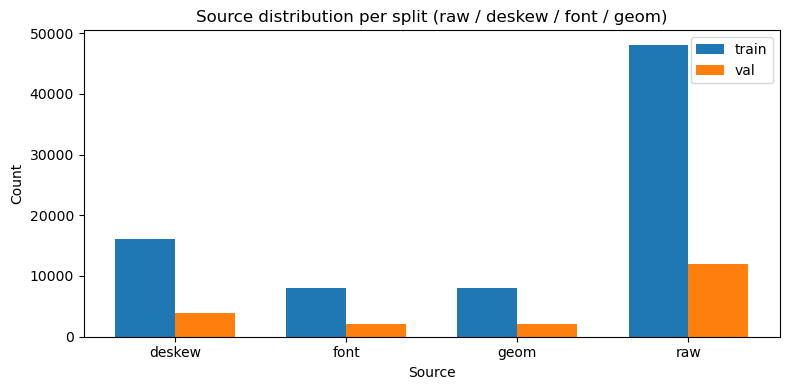



##########################################
### Task: digit - Digit classification (0-9)
##########################################

[EDA] Label distribution for task = digit
   label  train   val
0      0   7873  1968
1      1   8874  2218
2      2   7982  1996
3      3   8183  2046
4      4   7873  1968
5      5   7275  1819
6      6   7923  1980
7      7   8291  2073
8      8   7843  1961
9      9   7883  1971


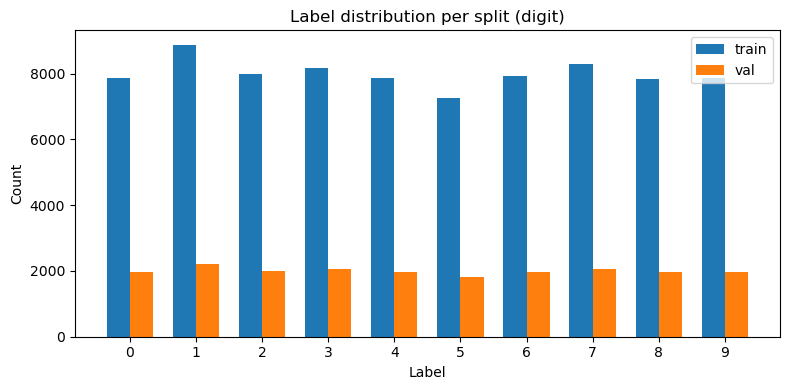

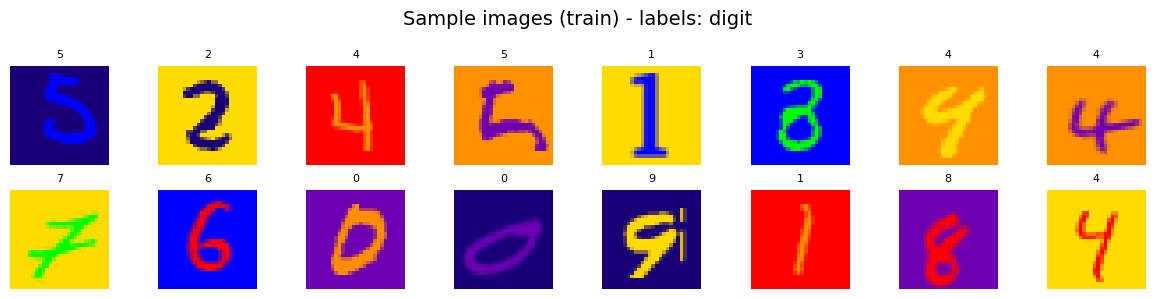


[TASK: digit] Training model: knn
[INFO] Training without GridSearch (fixed hyperparameters).

[VAL] metrics (macro) for knn
  accuracy : 0.9020
  precision: 0.9061
  recall   : 0.9006
  f1-score : 0.9018

[VAL] classification_report:
              precision    recall  f1-score   support

           0     0.9386    0.9553    0.9469      1968
           1     0.8275    0.9883    0.9008      2218
           2     0.9679    0.8617    0.9117      1996
           3     0.9098    0.8876    0.8986      2046
           4     0.9245    0.8582    0.8901      1968
           5     0.9120    0.8719    0.8915      1819
           6     0.9258    0.9576    0.9414      1980
           7     0.8909    0.9175    0.9040      2073
           8     0.9354    0.8338    0.8816      1961
           9     0.8292    0.8742    0.8511      1971

    accuracy                         0.9020     20000
   macro avg     0.9061    0.9006    0.9018     20000
weighted avg     0.9051    0.9020    0.9019     20000


[VAL

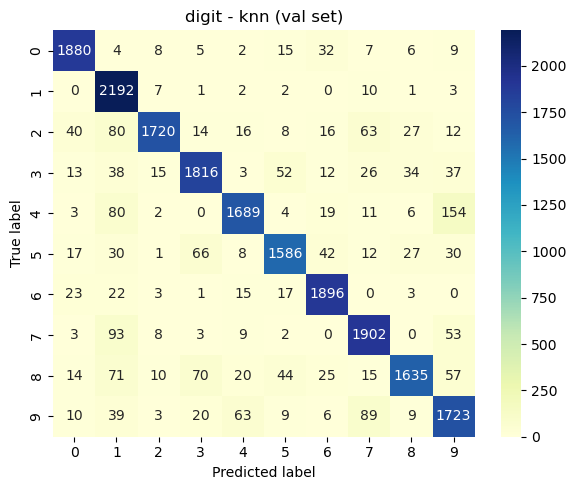

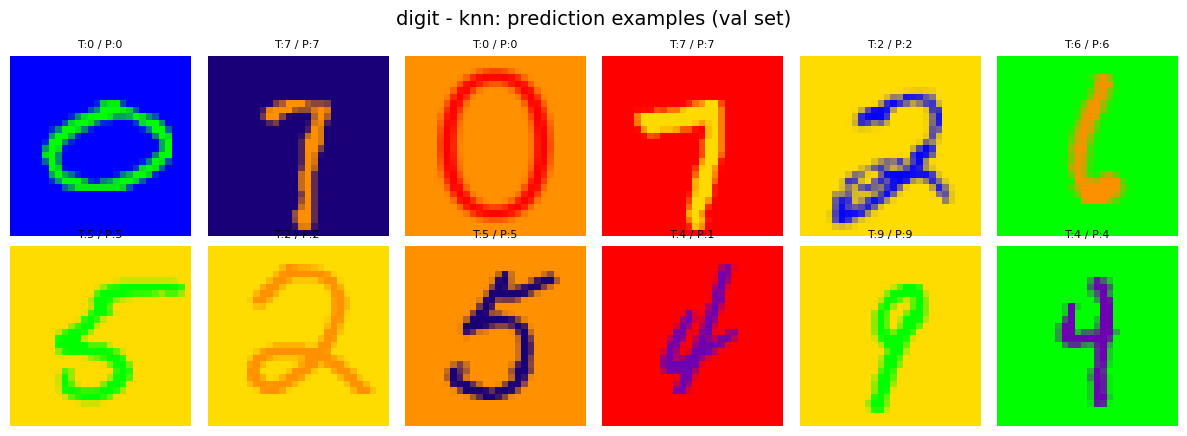


[TASK: digit] Training model: xgb
[INFO] Training without GridSearch (fixed hyperparameters).

[VAL] metrics (macro) for xgb
  accuracy : 0.9312
  precision: 0.9309
  recall   : 0.9308
  f1-score : 0.9308

[VAL] classification_report:
              precision    recall  f1-score   support

           0     0.9562    0.9654    0.9608      1968
           1     0.9537    0.9657    0.9597      2218
           2     0.9348    0.9188    0.9267      1996
           3     0.9350    0.8993    0.9168      2046
           4     0.9102    0.9421    0.9258      1968
           5     0.9354    0.9241    0.9298      1819
           6     0.9421    0.9455    0.9438      1980
           7     0.9408    0.9281    0.9344      2073
           8     0.8931    0.9159    0.9043      1961
           9     0.9082    0.9031    0.9056      1971

    accuracy                         0.9312     20000
   macro avg     0.9309    0.9308    0.9308     20000
weighted avg     0.9313    0.9312    0.9311     20000


[VAL

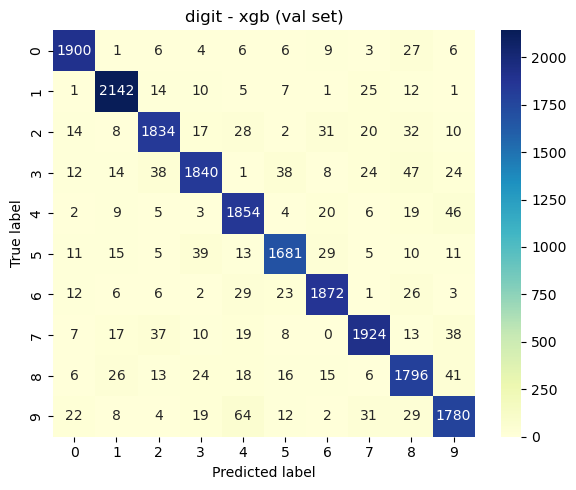

[INFO] Saved feature importance heatmap to: /Users/jaehun_jung/colored-mnist-classification/notebooks/results/figures/feat_importance_digit_xgb.png


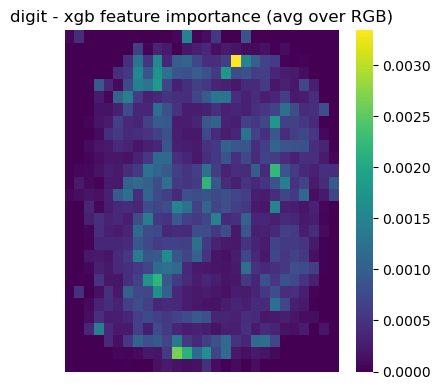

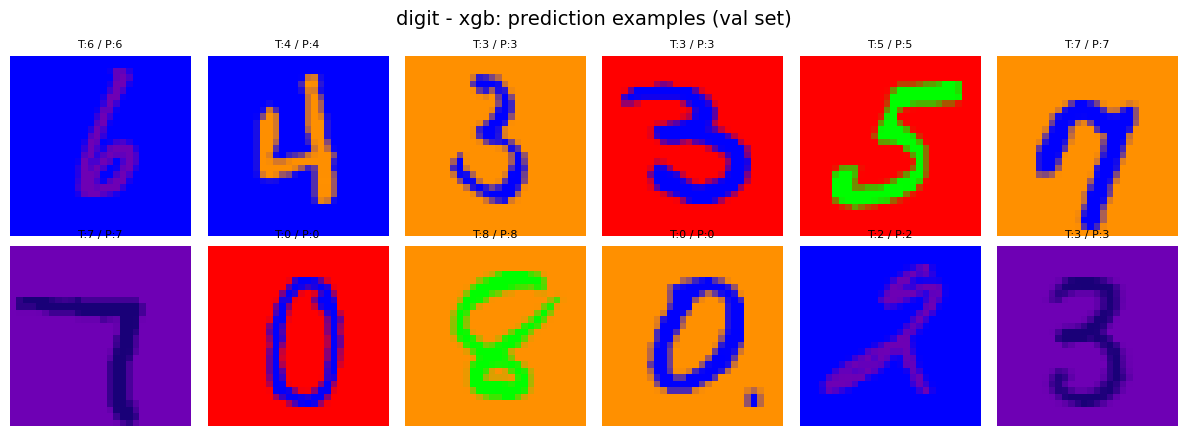



##########################################
### Task: fg - Foreground color classification (7 classes, ROYG BIV)
##########################################

[EDA] Label distribution for task = fg
   label  train   val
0      0  11428  2915
1      1  11391  2860
2      2  11323  2908
3      3  11589  2855
4      4  11385  2809
5      5  11547  2847
6      6  11337  2806


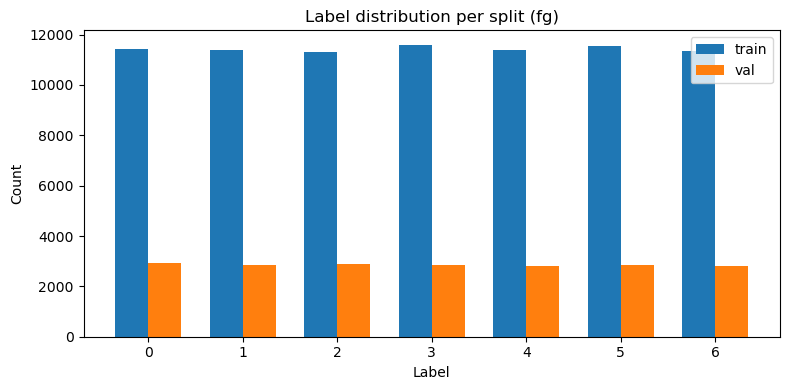

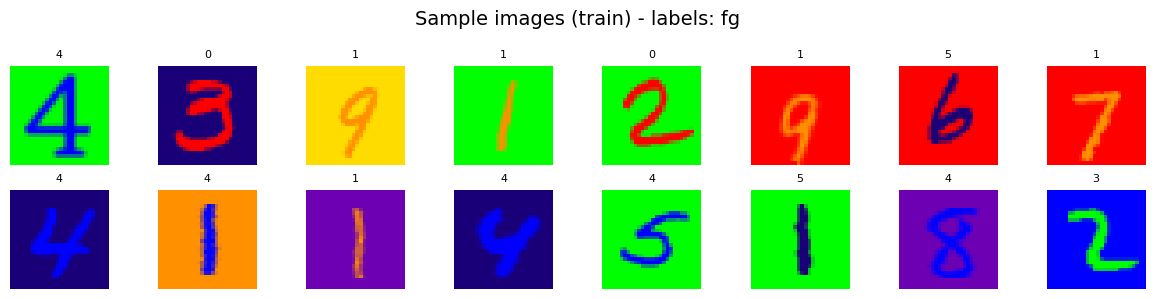


[TASK: fg] Training model: knn
[INFO] Training without GridSearch (fixed hyperparameters).

[VAL] metrics (macro) for knn
  accuracy : 0.8514
  precision: 0.8757
  recall   : 0.8516
  f1-score : 0.8513

[VAL] classification_report:
              precision    recall  f1-score   support

           0     0.9840    0.8844    0.9315      2915
           1     0.6687    0.9031    0.7684      2860
           2     0.9084    0.6479    0.7563      2908
           3     1.0000    0.9751    0.9874      2855
           4     0.9963    0.6757    0.8053      2809
           5     0.8369    0.9642    0.8960      2847
           6     0.7358    0.9109    0.8140      2806

    accuracy                         0.8514     20000
   macro avg     0.8757    0.8516    0.8513     20000
weighted avg     0.8762    0.8514    0.8514     20000


[VAL FINAL] fg - knn
  accuracy : 0.8514
  precision: 0.8757
  recall   : 0.8516
  f1-score : 0.8513
[INFO] Saved confusion matrix to: /Users/jaehun_jung/colored-mnist-c

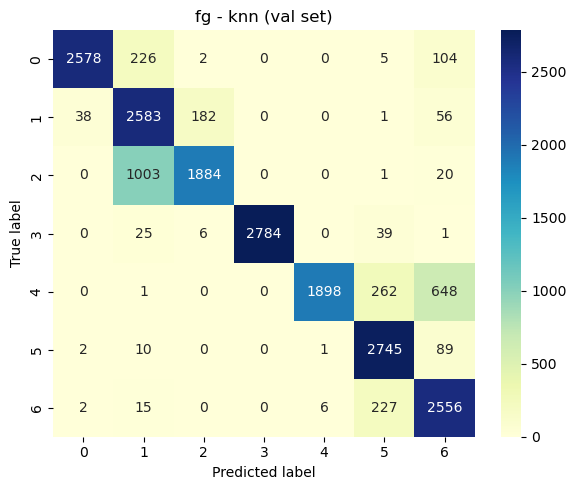

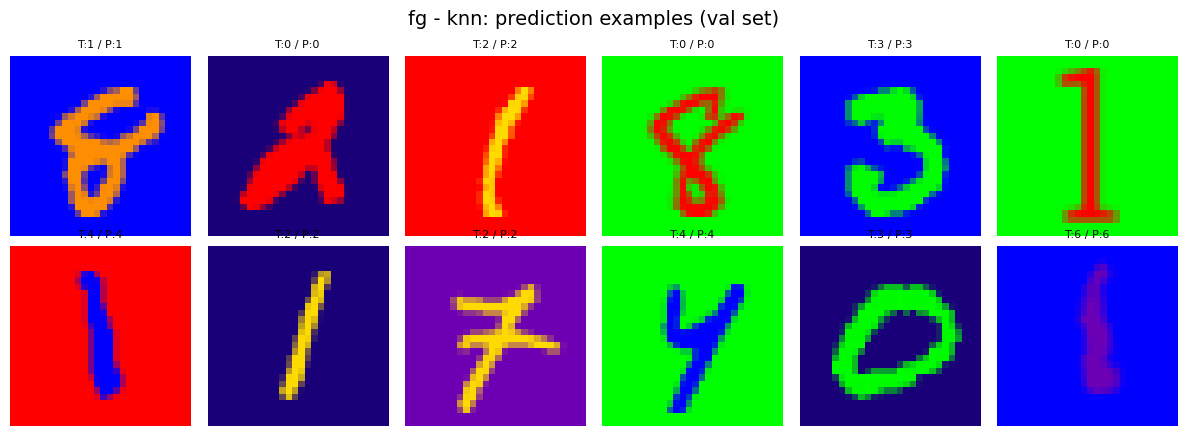


[TASK: fg] Training model: xgb
[INFO] Training without GridSearch (fixed hyperparameters).

[VAL] metrics (macro) for xgb
  accuracy : 0.9998
  precision: 0.9997
  recall   : 0.9998
  f1-score : 0.9997

[VAL] classification_report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      2915
           1     0.9990    1.0000    0.9995      2860
           2     1.0000    0.9990    0.9995      2908
           3     1.0000    1.0000    1.0000      2855
           4     1.0000    0.9996    0.9998      2809
           5     0.9996    1.0000    0.9998      2847
           6     0.9996    0.9996    0.9996      2806

    accuracy                         0.9998     20000
   macro avg     0.9997    0.9998    0.9997     20000
weighted avg     0.9998    0.9998    0.9998     20000


[VAL FINAL] fg - xgb
  accuracy : 0.9998
  precision: 0.9997
  recall   : 0.9998
  f1-score : 0.9997
[INFO] Saved confusion matrix to: /Users/jaehun_jung/colored-mnist-c

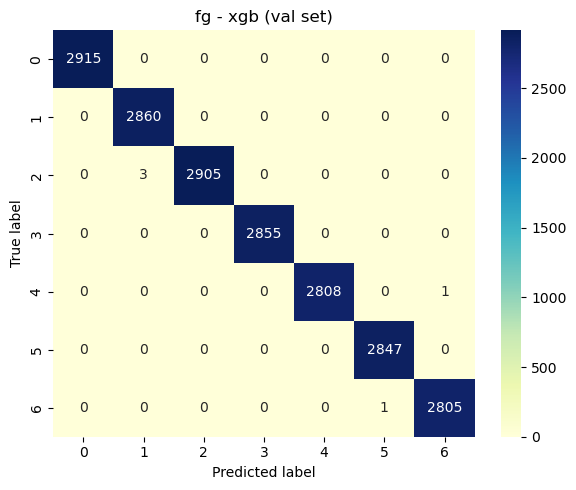

[INFO] Saved feature importance heatmap to: /Users/jaehun_jung/colored-mnist-classification/notebooks/results/figures/feat_importance_fg_xgb.png


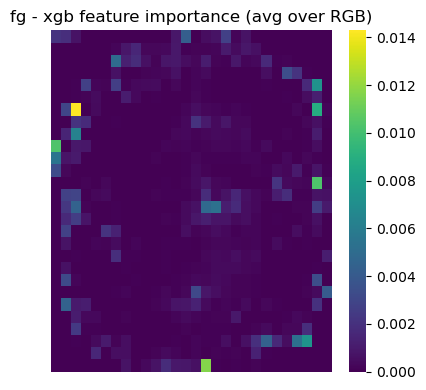

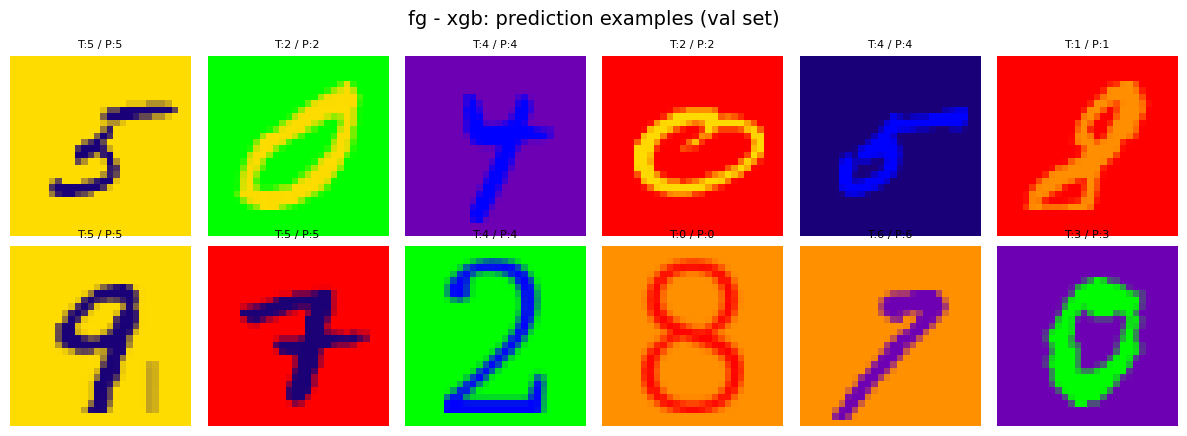



##########################################
### Task: bg - Background color classification (7 classes, ROYG BIV)
##########################################

[EDA] Label distribution for task = bg
   label  train   val
0      0  11411  2877
1      1  11299  2818
2      2  11570  2816
3      3  11472  2856
4      4  11619  3001
5      5  11408  2849
6      6  11221  2783


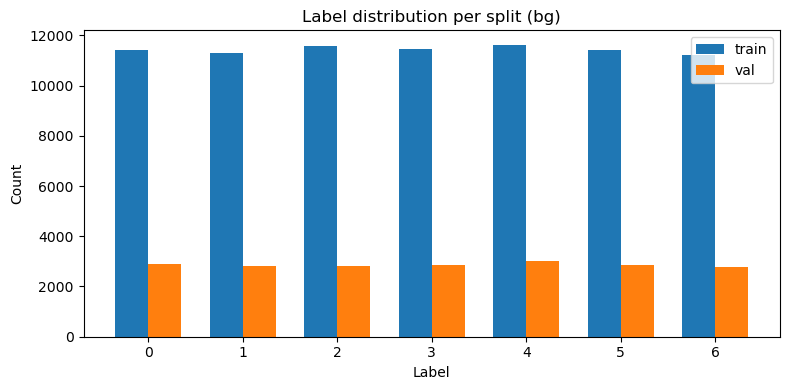

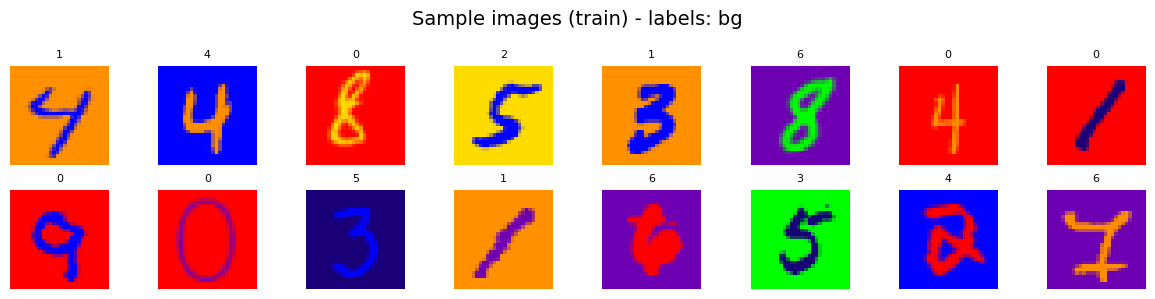


[TASK: bg] Training model: knn
[INFO] Training without GridSearch (fixed hyperparameters).

[VAL] metrics (macro) for knn
  accuracy : 0.9999
  precision: 0.9998
  recall   : 0.9998
  f1-score : 0.9998

[VAL] classification_report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      2877
           1     0.9989    1.0000    0.9995      2818
           2     1.0000    0.9989    0.9995      2816
           3     1.0000    1.0000    1.0000      2856
           4     1.0000    1.0000    1.0000      3001
           5     1.0000    1.0000    1.0000      2849
           6     1.0000    1.0000    1.0000      2783

    accuracy                         0.9999     20000
   macro avg     0.9998    0.9998    0.9998     20000
weighted avg     0.9999    0.9999    0.9998     20000


[VAL FINAL] bg - knn
  accuracy : 0.9999
  precision: 0.9998
  recall   : 0.9998
  f1-score : 0.9998
[INFO] Saved confusion matrix to: /Users/jaehun_jung/colored-mnist-c

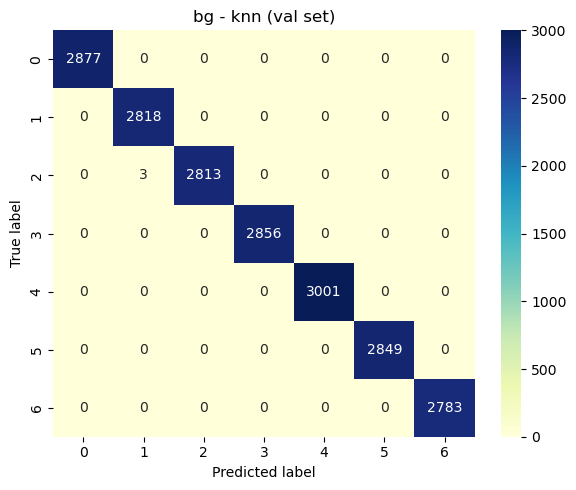

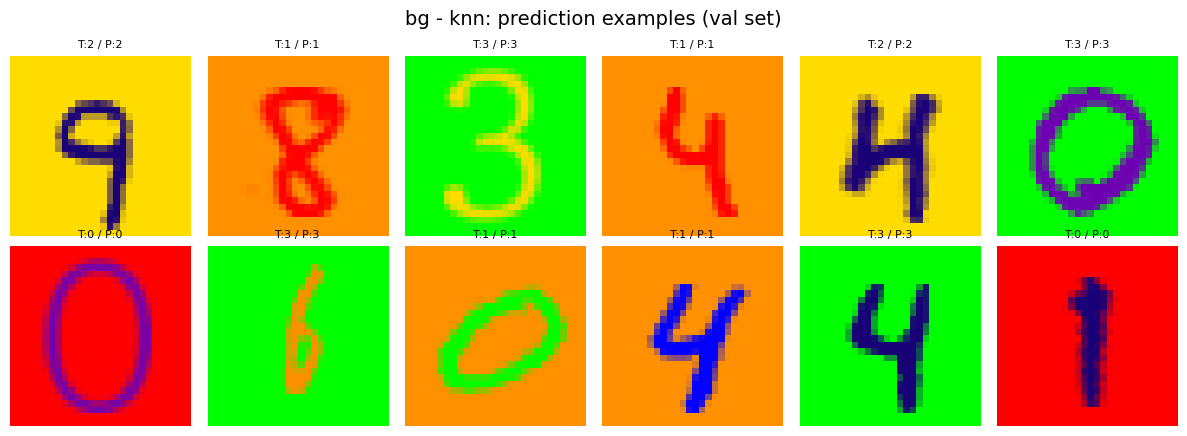


[TASK: bg] Training model: xgb
[INFO] Training without GridSearch (fixed hyperparameters).

[VAL] metrics (macro) for xgb
  accuracy : 1.0000
  precision: 1.0000
  recall   : 1.0000
  f1-score : 1.0000

[VAL] classification_report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      2877
           1     1.0000    1.0000    1.0000      2818
           2     1.0000    1.0000    1.0000      2816
           3     1.0000    1.0000    1.0000      2856
           4     1.0000    1.0000    1.0000      3001
           5     1.0000    1.0000    1.0000      2849
           6     1.0000    1.0000    1.0000      2783

    accuracy                         1.0000     20000
   macro avg     1.0000    1.0000    1.0000     20000
weighted avg     1.0000    1.0000    1.0000     20000


[VAL FINAL] bg - xgb
  accuracy : 1.0000
  precision: 1.0000
  recall   : 1.0000
  f1-score : 1.0000
[INFO] Saved confusion matrix to: /Users/jaehun_jung/colored-mnist-c

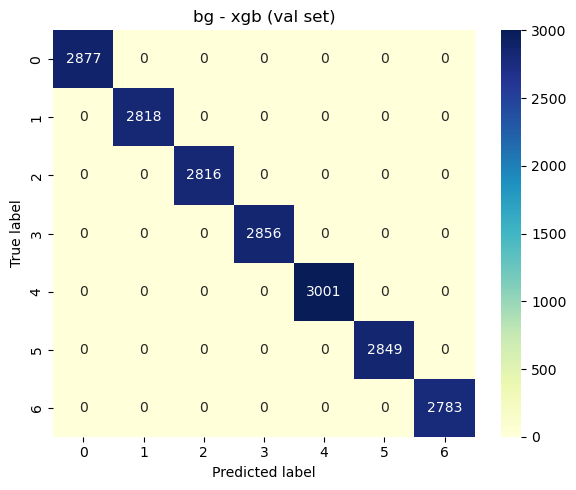

[INFO] Saved feature importance heatmap to: /Users/jaehun_jung/colored-mnist-classification/notebooks/results/figures/feat_importance_bg_xgb.png


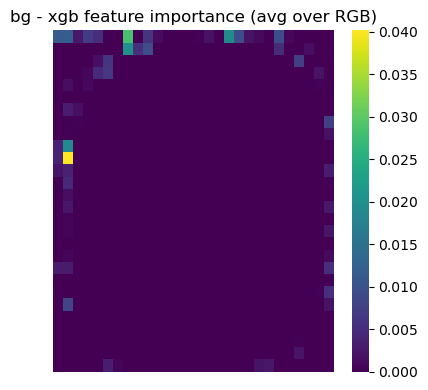

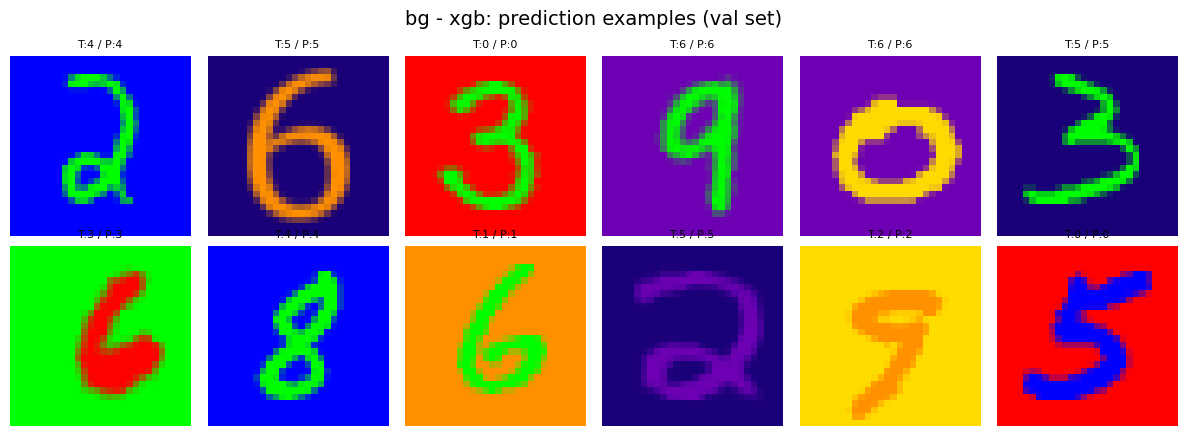

In [9]:
# ==========================================
# Cell 8. Main training loop over tasks/models
# ==========================================
all_results = []  # will store metrics for all (task, model, split)

# EDA: source distribution (once)
plot_source_distribution(source_train, source_val)

for task_name in ACTIVE_TASKS:
    info = TASK_LABEL_INFO[task_name]
    y_train_task = info["y_train"]
    y_val_task   = info["y_val"]
    task_desc    = info["task_desc"]

    print("\n\n##########################################")
    print(f"### Task: {task_name} - {task_desc}")
    print("##########################################")

    # EDA: label distribution
    plot_label_distribution_2way(y_train_task, y_val_task, task_name)

    # EDA: sample images (using training split, labels from this task)
    plot_sample_images(
        X_flat=X_train,
        y=y_train_task,
        title=f"Sample images (train) - labels: {task_name}",
        n_samples=16,
    )

    # Classes sorted for confusion matrix axis
    classes = np.sort(np.unique(y_train_task))

    # Dictionary to store trained pipelines for this task
    trained_pipelines = {}

    # Loop over models selected in ACTIVE_MODELS
    for model_name in ACTIVE_MODELS:
        # Train (with or without GridSearch depending on USE_GRIDSEARCH flag)
        use_grid = USE_GRIDSEARCH.get(model_name, False)
        best_pipe, val_metrics = train_single_model(
            model_name=model_name,
            X_train=X_train,
            y_train=y_train_task,
            X_val=X_val,
            y_val=y_val_task,
            task_name=task_name,
            use_gridsearch=use_grid,
        )

        trained_pipelines[model_name] = best_pipe

        # Evaluate on validation set (no separate test set yet)
        y_val_pred = best_pipe.predict(X_val)
        acc_val, prec_val, rec_val, f1_val = compute_metrics(
            y_val_task, y_val_pred, average="macro"
        )

        print(f"\n[VAL FINAL] {task_name} - {model_name}")
        print(f"  accuracy : {acc_val:.4f}")
        print(f"  precision: {prec_val:.4f}")
        print(f"  recall   : {rec_val:.4f}")
        print(f"  f1-score : {f1_val:.4f}")

        # Confusion matrix on validation set
        cm_title = f"{task_name} - {model_name} (val set)"
        cm_filename = f"cm_{task_name}_{model_name}_val.png"
        cm_path = os.path.join(RESULTS_FIGURES_DIR, cm_filename)
        plot_confusion_matrix(
            y_true=y_val_task,
            y_pred=y_val_pred,
            classes=classes,
            title=cm_title,
            save_path=cm_path,
        )

        # Feature importance for tree-based models (DecisionTree, RandomForest, XGBoost)
        if model_name in ["tree", "rf", "xgb"]:
            clf = best_pipe.named_steps["clf"]
            if hasattr(clf, "feature_importances_"):
                fi = clf.feature_importances_
                fi_title = f"{task_name} - {model_name} feature importance (avg over RGB)"
                fi_filename = f"feat_importance_{task_name}_{model_name}.png"
                fi_path = os.path.join(RESULTS_FIGURES_DIR, fi_filename)
                plot_feature_importance_heatmap(
                    feature_importances=fi,
                    title=fi_title,
                    save_path=fi_path,
                )
            else:
                print(f"[WARN] Model {model_name} does not expose feature_importances_.")

        # Qualitative prediction examples (true vs predicted labels) on val set
        show_prediction_examples(
            model_name=model_name,
            pipeline=best_pipe,
            X=X_val,
            y_true=y_val_task,
            task_name=task_name,
            n=12,
        )

        # Store validation metrics
        all_results.append({
            "task": task_name,
            "task_desc": task_desc,
            "model": model_name,
            "split": "val",
            "accuracy": acc_val,
            "precision": prec_val,
            "recall": rec_val,
            "f1": f1_val,
        })

In [10]:
# ==========================================
# Cell 9. Metrics table (for report) + save CSV
# ==========================================
results_df = pd.DataFrame(all_results)

# Sort by task, split, and accuracy (descending on accuracy)
results_df_sorted = results_df.sort_values(
    by=["task", "split", "accuracy"],
    ascending=[True, True, False],
).reset_index(drop=True)

print("\n\n===== Summary metrics table (all tasks / models) =====")
print(results_df_sorted)

# Save overall CSV
overall_csv_path = os.path.join(
    RESULTS_METRICS_DIR,
    "classical_ml_all_tasks_metrics.csv",
)
results_df_sorted.to_csv(overall_csv_path, index=False)
print("\n[INFO] Saved overall metrics CSV to:", overall_csv_path)

# Save per-task CSV for easier report usage / 03 notebook
for task_name in ACTIVE_TASKS:
    task_df = results_df_sorted[results_df_sorted["task"] == task_name]
    task_csv_path = os.path.join(
        RESULTS_METRICS_DIR,
        f"{task_name}_classical_ml_metrics.csv",
    )
    task_df.to_csv(task_csv_path, index=False)
    print(f"[INFO] Saved metrics CSV for task={task_name} to:", task_csv_path)

print("\n[INFO] Classical ML training & evaluation pipeline finished.")



===== Summary metrics table (all tasks / models) =====
    task                                          task_desc model split  \
0     bg  Background color classification (7 classes, RO...   xgb   val   
1     bg  Background color classification (7 classes, RO...   knn   val   
2  digit                         Digit classification (0-9)   xgb   val   
3  digit                         Digit classification (0-9)   knn   val   
4     fg  Foreground color classification (7 classes, RO...   xgb   val   
5     fg  Foreground color classification (7 classes, RO...   knn   val   

   accuracy  precision    recall        f1  
0   1.00000   1.000000  1.000000  1.000000  
1   0.99985   0.999848  0.999848  0.999848  
2   0.93115   0.930945  0.930807  0.930778  
3   0.90195   0.906147  0.900603  0.901768  
4   0.99975   0.999749  0.999751  0.999750  
5   0.85140   0.875711  0.851614  0.851282  

[INFO] Saved overall metrics CSV to: /Users/jaehun_jung/colored-mnist-classification/notebooks/result